# Deep Learning
## A

In [1]:
from matplotlib import pyplot
%matplotlib inline
import numpy as np
from pathlib import Path
import requests
import pickle
import gzip
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader


In [2]:
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"
if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)


In [27]:
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


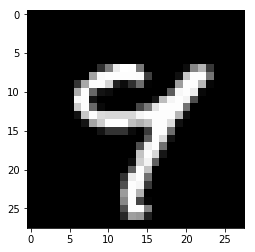

In [28]:
pyplot.imshow(x_train[54].reshape((28, 28)), cmap="gray")
print(x_train.shape)

In [120]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DNN(nn.Module):
    def __init__(self,n_inputs, n_hidden, n_outputs, activation):
        super(DNN, self).__init__()
        if type(activation) == nn.ReLU():
            self.model = nn.Sequential(
            nn.Linear(n_inputs, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_outputs))
            
        elif type(activation) == nn.LeakyReLU():
            self.model = nn.Sequential(
            nn.Linear(n_inputs, n_hidden), 
            nn.LeakyReLU(), 
            nn.Linear(n_hidden, n_hidden), 
            nn.LeakyReLU(), 
            nn.Linear(n_hidden, n_hidden),
            nn.LeakyReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.LeakyReLU(),
            nn.Linear(n_hidden, n_outputs))
            
        else:
            self.model = nn.Sequential(
            nn.Linear(n_inputs, n_hidden), 
            nn.ELU(), 
            nn.Linear(n_hidden, n_hidden), 
            nn.ELU(), 
            nn.Linear(n_hidden, n_hidden),
            nn.ELU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ELU(),
            nn.Linear(n_hidden, n_outputs))
    
    def forward(self, x):
        return self.model(x)

In [78]:
def init_weights(m):
    #print(m)
    if type(m) == nn.Linear:
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        #print(m.weight)

In [87]:
model = DNN(28*28,n_hidden=100, n_outputs=5)
model.apply(init_weights)

Linear(in_features=784, out_features=100, bias=True)
ELU(alpha=1.0)
Linear(in_features=100, out_features=100, bias=True)
ELU(alpha=1.0)
Linear(in_features=100, out_features=100, bias=True)
ELU(alpha=1.0)
Linear(in_features=100, out_features=100, bias=True)
ELU(alpha=1.0)
Linear(in_features=100, out_features=5, bias=True)
Sequential(
  (0): Linear(in_features=784, out_features=100, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ELU(alpha=1.0)
  (4): Linear(in_features=100, out_features=100, bias=True)
  (5): ELU(alpha=1.0)
  (6): Linear(in_features=100, out_features=100, bias=True)
  (7): ELU(alpha=1.0)
  (8): Linear(in_features=100, out_features=5, bias=True)
)
DNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ELU(al

DNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=100, out_features=5, bias=True)
  )
)

## B - ELU early stopping

In [29]:
x_train = np.concatenate((x_train,x_valid[:5000]),axis=0)
y_train = np.concatenate((y_train,y_valid[:5000]),axis=0)
x_valid = x_valid[:5000]
y_valid = y_valid[:5000]

X_train_zero_four = x_train[y_train < 5]
y_train_zero_four = y_train[y_train < 5]
X_valid_zero_four = x_valid[y_valid < 5]
y_valid_zero_four = y_valid[y_valid < 5]

X_train_zero_four, y_train_zero_four, X_valid_zero_four, y_valid_zero_four = map(
    torch.tensor, (X_train_zero_four, y_train_zero_four, X_valid_zero_four, y_valid_zero_four)
)


torch.Size([28076, 784])
torch.Size([28076])


In [49]:
n, c = X_train_zero_four.shape
print (X_train_zero_four.shape)
print (y_train_zero_four.shape)
print (X_valid_zero_four.shape)
print (y_valid_zero_four.shape)

torch.Size([28076, 784])
torch.Size([28076])
torch.Size([2538, 784])
torch.Size([2538])


In [39]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [90]:
def fit_early_stop(epochs, model, loss_func, opt, train_dl, valid_dl):
    bs = 20
    best_loss = np.infty
    epochs_without_progress = 0
    max_epochs_without_progress = 20
    PATH = './bestmodeltorch.pth'
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)
        
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb_val, yb_val) for xb_val, yb_val in valid_dl]
            )
            
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        val_accuracy = accuracy(model(X_valid_zero_four),y_valid_zero_four)
        if epoch % 5 == 0:
            print("Epoch:", epoch,
                  "\tValidation accuracy: {:.3f}%".format(val_accuracy * 100),
                  "\tLoss: {:.5f}".format(val_loss))

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'loss': loss_func,
            }, PATH)
            epochs_without_progress = 0
        else:
            epochs_without_progress += 1
            if epochs_without_progress > max_epochs_without_progress:
                print("Early stopping")
                break

In [83]:
bs = 20
n_batches = int(np.ceil( n / bs))

train_ds = TensorDataset(X_train_zero_four, y_train_zero_four)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(X_valid_zero_four, y_valid_zero_four)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)


In [92]:
model = DNN(28*28,n_hidden=100, n_outputs=5)
model.apply(init_weights)
loss_func = F.cross_entropy
#opt = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
opt = optim.Adam(model.parameters(),lr = 0.01)
epochs = 100
fit_early_stop(epochs, model, loss_func, opt, train_dl, valid_dl)

Linear(in_features=784, out_features=100, bias=True)
ELU(alpha=1.0)
Linear(in_features=100, out_features=100, bias=True)
ELU(alpha=1.0)
Linear(in_features=100, out_features=100, bias=True)
ELU(alpha=1.0)
Linear(in_features=100, out_features=100, bias=True)
ELU(alpha=1.0)
Linear(in_features=100, out_features=5, bias=True)
Sequential(
  (0): Linear(in_features=784, out_features=100, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ELU(alpha=1.0)
  (4): Linear(in_features=100, out_features=100, bias=True)
  (5): ELU(alpha=1.0)
  (6): Linear(in_features=100, out_features=100, bias=True)
  (7): ELU(alpha=1.0)
  (8): Linear(in_features=100, out_features=5, bias=True)
)
DNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ELU(al

## C

In [219]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError

class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer_class=opt,
                 learning_rate=0.01, batch_size=20, activation=nn.ELU(),
                 batch_norm_momentum=None, dropout_rate=None, random_state=None,t_dl=None,v_dl=None,loss=None):
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        self.train_dl = t_dl
        self.valid_dl = v_dl
        self.loss_func = loss
        if batch_norm_momentum:
            tmp = DNN_BatchNorm(28*28,n_hidden=self.n_neurons, n_outputs=5,activation=self.activation,mu=batch_norm_momentum)
        elif dropout_rate:
            tmp = DNN_DropOut(28*28,n_hidden=self.n_neurons, n_outputs=5,activation=self.activation,rate=dropout_rate)
        else:
            tmp = DNN(28*28,n_hidden=self.n_neurons, n_outputs=5,activation=self.activation)
        
        self.model = tmp
    
    def _dnn(self):
        model = DNN(28*28,n_hidden=self.n_neurons, n_outputs=5)
        model.apply(init_weights)
        return model
        
    
    def loss_batch(model, loss_func, xb, yb, opt=None):
        loss = loss_func(model(xb), yb)
        if opt is not None:
            loss.backward()
            opt.step()
            opt.zero_grad()

        return loss.item(), len(xb)

    def get_data(train_ds, valid_ds, bs):
        return (DataLoader(train_ds, batch_size=bs, shuffle=True), DataLoader(valid_ds, batch_size=bs * 2),)

    def accuracy(out, yb):
        preds = torch.argmax(out, dim=1)
        return (preds == yb).float().mean()
    
    def init_weights(self):
        #print(m)
        if type(self.model) == nn.Linear:
            nn.init.kaiming_normal_(self.model.weight, mode='fan_out', nonlinearity='relu')
            #print(m.weight)
    def fit_early_stop(self, epochs, loss_func, opt, train_dl, valid_dl,path):
        model = self.model
        bs = self.batch_size
        best_loss = np.infty
        epochs_without_progress = 0
        max_epochs_without_progress = 20
        PATH = path
        for epoch in range(epochs):
            model.train()
            for xb, yb in train_dl:
                loss_batch(model, loss_func, xb, yb, opt)
        
            model.eval()
            with torch.no_grad():
                losses, nums = zip(*[loss_batch(model, loss_func, xb_val, yb_val) for xb_val, yb_val in valid_dl])
            
            val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            val_accuracy = accuracy(model(X_valid_zero_four),y_valid_zero_four)
            if epoch % 5 == 0:
                print("Epoch:", epoch,
                  "\tValidation accuracy: {:.3f}%".format(val_accuracy * 100),
                  "\tLoss: {:.5f}".format(val_loss))

            if val_loss < best_loss:
                best_loss = val_loss
                torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'loss': loss_func,
                }, PATH)
                epochs_without_progress = 0
            else:
                epochs_without_progress += 1
                if epochs_without_progress > max_epochs_without_progress:
                    print("Early stopping")
                    break
    def set_dataloader(self,train_dl,val_dl):
        self.train_dl = train_dl
        self.valid_dl = val_dl
        
    def fit(self, X, y, n_epochs=100, X_valid=None, y_valid=None):
        n_inputs = X.shape[1]
        self.classes_ = np.unique(y)
        n_outputs = len(self.classes_)
        model = self.model
        self.optimizer_class = optim.Adam(model.parameters(),lr = 0.01)
        bs = self.batch_size
        best_loss = np.infty
        epochs_without_progress = 0
        max_epochs_without_progress = 5
        for epoch in range(epochs):
            model.train()
            rnd_idx = np.random.permutation(len(X))
            for rnd_indices in np.array_split(rnd_idx, len(X_train_zero_four) // bs):
                xb, yb = X[rnd_indices], y[rnd_indices]
                loss_batch(model, self.loss_func, xb, yb, self.optimizer_class)
            if X_valid is not None and y_valid is not None:
                model.eval()
                with torch.no_grad():
                    losses, nums = zip(*[loss_batch(model, loss_func, xb_val, yb_val) for xb_val, yb_val in self.valid_dl])
                val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
                val_accuracy = accuracy(model(X_valid_zero_four),y_valid_zero_four)
                if epoch % 5 == 0:
                    print("Epoch:", epoch,
                          "\tValidation accuracy: {:.3f}%".format(val_accuracy * 100),
                          "\tLoss: {:.5f}".format(val_loss))
                if val_loss < best_loss:
                    best_loss = val_loss
                    torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': opt.state_dict(),
                    'loss': loss_func,
                    }, "./test.pth")
                    epochs_without_progress = 0
                else:
                    epochs_without_progress += 1
                    if epochs_without_progress > max_epochs_without_progress:
                        print("Early stopping")
                        break
            else:
                model.eval()
                with torch.no_grad():
                    losses, nums = zip(*[loss_batch(model, loss_func, xb_val, yb_val) for xb_val, yb_val in self.train_dl])
                train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
                train_accuracy = accuracy(model(X),y)
                if epoch % 5 == 0:
                    print("{}\tLast training batch loss: {:.6f}\tAccuracy: {:.2f}%".format(epoch, train_loss, train_accuracy * 100))


In [127]:
dnn_clf = DNNClassifier(random_state=42,activation=nn.LeakyReLU())
dnn_clf.init_weights()

In [128]:
loss_func = F.cross_entropy
#opt = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
opt = optim.Adam(dnn_clf.model.parameters(),lr = 0.01)
epochs = 100
dnn_clf.fit_early_stop(epochs, loss_func, opt, train_dl, valid_dl,'./vannilla.pth')

Epoch: 0 	Validation accuracy: 96.375% 	Loss: 0.13574
Epoch: 5 	Validation accuracy: 98.503% 	Loss: 0.06506
Epoch: 10 	Validation accuracy: 97.124% 	Loss: 0.08364
Epoch: 15 	Validation accuracy: 96.730% 	Loss: 0.14521
Epoch: 20 	Validation accuracy: 98.739% 	Loss: 0.07402
Epoch: 25 	Validation accuracy: 95.587% 	Loss: 0.25071
Epoch: 30 	Validation accuracy: 67.888% 	Loss: 0.73054
Early stopping


In [220]:
test = DNNClassifier(random_state=42,t_dl=train_dl,v_dl=valid_dl,loss=loss_func)
test.fit(X_train_zero_four, y_train_zero_four, n_epochs=100,X_valid=X_valid_zero_four, y_valid=y_valid_zero_four)

Epoch: 0 	Validation accuracy: 95.942% 	Loss: 0.12250
Epoch: 5 	Validation accuracy: 98.306% 	Loss: 0.06976
Early stopping


## C - cross validation


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [50, 80, 120],
    "batch_size": [10, 50, 100],
    "learning_rate": [0.01, 0.1, 0.2],
    "activation": [nn.ReLU(), nn.ELU(), nn.LeakyReLU()],
}
rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42,t_dl=train_dl,v_dl=valid_dl,loss=loss_func),
                                param_distribs, n_iter=30,
                                cv=3, random_state=42, verbose=2)

rnd_search.fit(X_train_zero_four, y_train_zero_four, n_epochs=100,X_valid=X_valid_zero_four, y_valid=y_valid_zero_four)

In [ ]:

class DNN_BatchNorm(nn.Module):
    def __init__(self,n_inputs, n_hidden, n_outputs, activation,mu):
        super(DNN_BatchNorm, self).__init__()
        if isinstance(activation,type(nn.ReLU())):
            print("ReLU")
            self.model = nn.Sequential(
            nn.Linear(n_inputs, n_hidden),
            nn.BatchNorm1d(n_hidden,momentum=mu), 
            nn.ReLU(), 
            nn.Linear(n_hidden, n_hidden),
            nn.BatchNorm1d(n_hidden,momentum=mu),
            nn.ReLU(), 
            nn.Linear(n_hidden, n_hidden),
            nn.BatchNorm1d(n_hidden,momentum=mu), 
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.BatchNorm1d(n_hidden,momentum=mu), 
            nn.ReLU(),
            nn.Linear(n_hidden, n_outputs))
            
        elif isinstance(activation,type(nn.LeakyReLU())):
            print("leaky")
            self.model = nn.Sequential(
            nn.Linear(n_inputs, n_hidden), 
            nn.BatchNorm1d(n_hidden,momentum=mu),
            nn.LeakyReLU(), 
            nn.Linear(n_hidden, n_hidden),
            nn.BatchNorm1d(n_hidden,momentum=mu),
            nn.LeakyReLU(), 
            nn.Linear(n_hidden, n_hidden),
            nn.BatchNorm1d(n_hidden,momentum=mu),
            nn.LeakyReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.BatchNorm1d(n_hidden,momentum=mu),
            nn.LeakyReLU(),
            nn.Linear(n_hidden, n_outputs))
            
        else:
            print("elu")
            self.model = nn.Sequential(
            nn.Linear(n_inputs, n_hidden),
            nn.BatchNorm1d(n_hidden,momentum=mu),
            nn.ELU(), 
            nn.Linear(n_hidden, n_hidden),
            nn.BatchNorm1d(n_hidden,momentum=mu),
            nn.ELU(), 
            nn.Linear(n_hidden, n_hidden),
            nn.BatchNorm1d(n_hidden,momentum=mu),
            nn.ELU(),
            nn.Linear(n_hidden, n_hidden),
            nn.BatchNorm1d(n_hidden,momentum=mu),
            nn.ELU(),
            nn.Linear(n_hidden, n_outputs))
    
    def forward(self, x):
        return self.model(x)

In [199]:

class DNN_DropOut(nn.Module):
    def __init__(self,n_inputs, n_hidden, n_outputs, activation,rate):
        super(DNN_DropOut, self).__init__()
        self.rate = rate
        if isinstance(activation,type(nn.ReLU())):
            print("relu")
            self.model = nn.Sequential(
            nn.Linear(n_inputs, n_hidden), 
            nn.ReLU(),
            nn.Dropout(p=rate),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Dropout(p=rate),
            nn.Linear(n_hidden, n_hidden), 
            nn.ReLU(),
            nn.Dropout(p=rate),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Dropout(p=rate),
            nn.Linear(n_hidden, n_outputs))
            
        elif isinstance(activation,type(nn.LeakyReLU())):
            print("leaky relu")
            self.model = nn.Sequential(
            nn.Linear(n_inputs, n_hidden), 
            nn.LeakyReLU(),
            nn.Dropout(p=rate),
            nn.Linear(n_hidden, n_hidden),
            nn.LeakyReLU(),
            nn.Dropout(p=rate),
            nn.Linear(n_hidden, n_hidden),
            nn.LeakyReLU(),
            nn.Dropout(p=rate),
            nn.Linear(n_hidden, n_hidden),
            nn.LeakyReLU(),
            nn.Dropout(p=rate),
            nn.Linear(n_hidden, n_outputs))
            
        else:
            print("elu")
            self.model = nn.Sequential(
            nn.Linear(n_inputs, n_hidden),
            nn.ELU(), 
            nn.Dropout(p=rate),
            nn.Linear(n_hidden, n_hidden),
            nn.ELU(),
            nn.Dropout(p=rate),
            nn.Linear(n_hidden, n_hidden),
            nn.ELU(),
            nn.Dropout(p=rate),
            nn.Linear(n_hidden, n_hidden),
            nn.ELU(),
            nn.Dropout(p=rate),
            nn.Linear(n_hidden, n_outputs))
        #self.dropout = nn.Dropout(p=self.rate)
    def forward(self, x):
        return self.model(x)

## D - Batch normalization

In [129]:
dnn_clf = DNNClassifier(random_state=42,activation=nn.LeakyReLU(),batch_norm_momentum=0.9)
dnn_clf.init_weights()
loss_func = F.cross_entropy
#opt = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
opt = optim.Adam(dnn_clf.model.parameters(),lr = 0.01)
epochs = 100
dnn_clf.fit_early_stop(epochs, loss_func, opt, train_dl, valid_dl,'./batchnorm.pth')

Epoch: 0 	Validation accuracy: 98.069% 	Loss: 0.07346
Epoch: 5 	Validation accuracy: 99.015% 	Loss: 0.02584
Epoch: 10 	Validation accuracy: 99.488% 	Loss: 0.01801
Epoch: 15 	Validation accuracy: 99.921% 	Loss: 0.00473
Epoch: 20 	Validation accuracy: 99.606% 	Loss: 0.01003
Epoch: 25 	Validation accuracy: 99.448% 	Loss: 0.01613
Epoch: 30 	Validation accuracy: 99.685% 	Loss: 0.00824
Epoch: 35 	Validation accuracy: 99.921% 	Loss: 0.00223
Epoch: 40 	Validation accuracy: 99.882% 	Loss: 0.00331
Epoch: 45 	Validation accuracy: 99.961% 	Loss: 0.00306
Epoch: 50 	Validation accuracy: 100.000% 	Loss: 0.00115
Epoch: 55 	Validation accuracy: 99.567% 	Loss: 0.00920
Epoch: 60 	Validation accuracy: 99.645% 	Loss: 0.00805
Epoch: 65 	Validation accuracy: 99.842% 	Loss: 0.00620
Epoch: 70 	Validation accuracy: 99.842% 	Loss: 0.00299
Epoch: 75 	Validation accuracy: 99.488% 	Loss: 0.01661
Epoch: 80 	Validation accuracy: 99.842% 	Loss: 0.00457
Epoch: 85 	Validation accuracy: 100.000% 	Loss: 0.00057
Early stop

## E - Dropout Regularization

In [193]:
dnn_clfe = DNNClassifier(random_state=42,activation=nn.ReLU(),dropout_rate=0.50)
dnn_clfe.init_weights()
loss_func = F.cross_entropy
#opt = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
opt = optim.Adam(dnn_clfe.model.parameters(),lr = 0.01)
epochs = 100
dnn_clfe.fit_early_stop(epochs, loss_func, opt, train_dl, valid_dl,'./dropout.pth')

relu
Epoch: 0 	Validation accuracy: 91.411% 	Loss: 0.23804
Epoch: 5 	Validation accuracy: 88.534% 	Loss: 0.30492
Epoch: 10 	Validation accuracy: 90.071% 	Loss: 0.31291
Epoch: 15 	Validation accuracy: 92.947% 	Loss: 0.26837
Epoch: 20 	Validation accuracy: 94.287% 	Loss: 0.20364
Epoch: 25 	Validation accuracy: 92.356% 	Loss: 0.23833
Epoch: 30 	Validation accuracy: 92.632% 	Loss: 0.26522
Epoch: 35 	Validation accuracy: 94.050% 	Loss: 0.24215
Early stopping


In [202]:
dnn_clfe = DNNClassifier(random_state=42,activation=nn.LeakyReLU(),dropout_rate=0.50)
#dnn_clfe.init_weights()
loss_func = F.cross_entropy
#opt = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
opt = optim.Adam(dnn_clfe.model.parameters(),lr = 0.01)
epochs = 100
dnn_clfe.fit_early_stop(epochs, loss_func, opt, train_dl, valid_dl,'./dropout2.pth')

leaky relu
Epoch: 0 	Validation accuracy: 86.840% 	Loss: 0.32394
Epoch: 5 	Validation accuracy: 79.472% 	Loss: 0.63043
Epoch: 10 	Validation accuracy: 67.652% 	Loss: 0.83198
Epoch: 15 	Validation accuracy: 50.473% 	Loss: 1.04839
Epoch: 20 	Validation accuracy: 49.882% 	Loss: 1.05426
Early stopping
